# Feature Importance Analysis and Filtering with Random Forests

This notebook evaluates which **acoustic features** are most informative for distinguishing **healthy vs. pathological speech**,  
and then uses these features in a filtering pipeline to clean synthesized datasets.

### Goals
- Train a **Random Forest classifier** on labeled real data.  
- Rank features by their **Gini importance** (a measure of how much each feature reduces impurity in the decision trees).  
- Report the **top-ranked features**.  
- Apply the trained classifier to a target dataset (e.g., synthesized speech) and filter out samples predicted as **healthy**.  

### Input
- `audio_features_out.csv`: real, labeled dataset with extracted features.  
  - Column `is_health` indicates health status (`1` = healthy, `0` = pathological).  
- `audio_features_synth.csv`: target dataset to filter (synthesized or additional pathological samples).  
- `all_features_gini_ranked.csv`: ranked list of features by importance.  

### Output
- Ranked list of features by **Gini importance**.  
- CSV exports of:  
  - Top-15 features (`top15_gini_features.csv`)  
  - Full ranking (`all_features_gini_ranked.csv`)  
  - Predictions on the target dataset (`predictions_on_target.csv`)  
  - Filtered dataset with only predicted pathological samples (`pathological_filtered.csv`).  


# 15 Most Important Features (by Gini Importance)

In [18]:
# ==============================
# Top-10 features by Gini importance
# ==============================
# Config
FEATURES_CSV   = "./audio_features_out.csv"   # path to the CSV produced by the extractor
LABEL_COL      = "is_health"                  # column that says whether the sample is healthy
EXCLUDE_COLS   = {"audio_path", "text", "session_id", "error"}  # non-features to drop
N_TREES        = 1000
RANDOM_STATE   = 42

In [26]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ---------- Load ----------
df = pd.read_csv(FEATURES_CSV)

if LABEL_COL not in df.columns:
    raise ValueError(f"Label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

# ---------- Robust label mapping ----------
# We will create y_pathological = 1 for pathological, 0 for healthy.
def to_bool_health(v):
    if pd.isna(v): return np.nan
    s = str(v).strip().lower()
    if s in {"1","true","t","yes","y","healthy"}:  # healthy
        return 1
    if s in {"0","false","f","no","n","pathological","pathology","pat"}:  # not healthy
        return 0
    # try numeric
    try:
        f = float(s)
        # assume 1=healthy, 0=pathological if strictly 0/1
        if f in (0.0, 1.0):
            return int(f)
    except:
        pass
    return np.nan

health_bool = df[LABEL_COL].apply(to_bool_health)
if health_bool.isna().any():
    raise ValueError(
        "Some labels in is_health could not be parsed. "
        "Please standardize to {0/1, True/False, yes/no, healthy/pathological}."
    )

# pathological = 1 if not healthy
y = (1 - health_bool).astype(int).values

# ---------- Build feature matrix ----------
drop_cols = set([LABEL_COL]) | EXCLUDE_COLS
X = df.drop(columns=[c for c in df.columns if c in drop_cols])

# Keep only numeric columns (RF needs numeric)
X = X.select_dtypes(include=[np.number]).copy()

# Fill NaNs with column medians
for c in X.columns:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())

# Quick sanity
assert len(X) == len(y) and X.shape[1] > 0, "Feature matrix is empty or misaligned."

# ---------- Train RF (Gini importance) ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
rf = RandomForestClassifier(
    n_estimators=N_TREES,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced_subsample",
    criterion="gini",
    max_features="sqrt",
)
rf.fit(X_train, y_train)

print("Held-out performance (for context):")
print(classification_report(y_test, rf.predict(X_test), target_names=["healthy(0)","pathological(1)"]))

# ---------- Rank importances ----------
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top15 = imp.head(15).to_frame("gini_importance")

# Add class-wise means to show directionality (not part of Gini, just helpful)
means = df.assign(_y=y).groupby("_y")[X.columns].mean().rename(index={0:"healthy_mean",1:"pathological_mean"})
top15 = top15.join(means.T.loc[:, ["healthy_mean", "pathological_mean"]])

# Save + display
top15_path = "top15_gini_features.csv"
top15.to_csv(top15_path)
print("\nTop-15 features by Gini importance (saved to top15_gini_features.csv):")
display(top15)

# If you also want the full ranked list:
full_rank_path = "all_features_gini_ranked.csv"
imp.to_frame("gini_importance").to_csv(full_rank_path)
print(f"\nFull ranked list saved to {full_rank_path}")


Held-out performance (for context):
                 precision    recall  f1-score   support

     healthy(0)       0.87      0.92      0.89        36
pathological(1)       0.88      0.82      0.85        28

       accuracy                           0.88        64
      macro avg       0.88      0.87      0.87        64
   weighted avg       0.88      0.88      0.87        64


Top-15 features by Gini importance (saved to top15_gini_features.csv):


,gini_importance,healthy_mean,pathological_mean
hnr_mean,0.175490,12.290471,2.834379
nhr_mean,0.173725,10.325148,1.903261
mean_pitch,0.088516,168.200367,130.527787
jitter_local_percent,0.080545,2.099072,5.308571
shimmer_local_percent,0.058262,11.232805,18.689299
spectral_centroid,0.042919,760.705399,1485.460413
spectral_slope,0.037043,-9.605625,-4.328553
zcr_mean,0.029676,2413.017144,3222.318236
std_pitch,0.028905,51.503224,69.604382
std_intensity,0.026699,22.465571,15.204507



Full ranked list saved to all_features_gini_ranked.csv


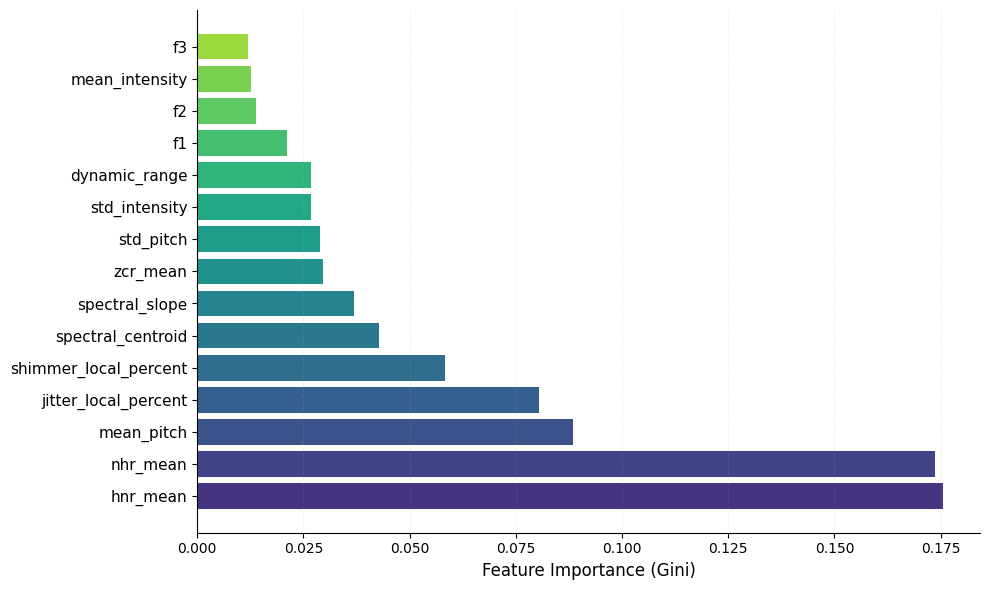

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(10, 6))

cmap = plt.cm.viridis
colors = cmap(np.linspace(0.15, 0.85, len(top15)))

bars = plt.barh(range(len(top15)), top15["gini_importance"].values, color=colors, edgecolor="none")

plt.yticks(range(len(top15)), top15.index, fontsize=11)

plt.xlabel("Feature Importance (Gini)", fontsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:0.3f}"))

plt.grid(axis='x', alpha=0.15, linestyle='--', linewidth=0.8)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()


# Filtering Synthesized Pathological Samples with Random Forest Classifier Trained on Real Data

In [ ]:
# ============================================
# RF filter: train on REAL, apply to PATHO set
# ============================================
from pathlib import Path
from typing import List, Optional
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

# -------------------
# Config
# -------------------
FEATURES_CSV   = "./audio_features_out.csv"      # real, labeled
TARGET_CSV             = "./filtered_synthesized_data_byWasserstein.csv"    # synthesized (to filter)
GINI_RANKED_PATH       = "./all_features_gini_ranked.csv"  
TOP_K_FEATURES: Optional[int] = 15                       # set None to use all numeric

LABEL_COL              = "is_health"                     # 1=healthy, 0=pathological (or strings)
EXCLUDE_COLS           = {"audio_path", "filename_path", "text", "session_id", "error"}
ID_COL_CANDIDATES      = ["audio_path", "filename_path", "id"]

# RF settings
N_TREES        = 1000
RANDOM_STATE   = 42
N_JOBS         = -1
CRITERION      = "gini"
CLASS_WEIGHT   = "balanced_subsample"
MAX_FEATURES   = "sqrt"

# Filtering rule
KEEP_IF_PATHO_PROBA_AT_LEAST = 0.50   # e.g., 0.80 for stricter filtering

# Outputs
PREDICTIONS_OUT = "./predictions_on_target.csv"
FILTERED_OUT    = "./pathological_filtered.csv"

# -------------------
# Helpers
# -------------------
def choose_id_col(df: pd.DataFrame, candidates: List[str]) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    return df.columns[0]  # fallback

def to_bool_health(v):
    if pd.isna(v): return np.nan
    s = str(v).strip().lower()
    if s in {"1","true","t","yes","y","healthy","heal","h"}: return 1
    if s in {"0","false","f","no","n","pathological","pathology","pat","p"}: return 0
    try:
        f = float(s)
        if f in (0.0, 1.0): return int(f)
    except Exception:
        pass
    return np.nan

def build_feature_list(df: pd.DataFrame, exclude: set, ranked_csv: Optional[str], top_k: Optional[int]):
    # numeric only, minus exclude
    numeric = df.select_dtypes(include=[np.number]).columns.difference(exclude).tolist()

    if ranked_csv and Path(ranked_csv).exists():
        rank = pd.read_csv(ranked_csv, index_col=0)
        ranked_names = [c for c in rank.index.tolist() if c in numeric]
        if top_k is not None:
            ranked_names = ranked_names[:top_k]
        # keep order as in ranked list
        return ranked_names if ranked_names else numeric
    else:
        if top_k is not None:
            # simple fallback: take top_k most variant features
            var = df[numeric].var().sort_values(ascending=False)
            return var.index.tolist()[:top_k]
        return numeric

def prepare_matrix(df: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    X = df[features].copy()
    # median impute (column-wise)
    for c in X.columns:
        if X[c].isna().any():
            X[c] = X[c].fillna(X[c].median())
    return X

# -------------------
# Load & train on REAL
# -------------------
df_real = pd.read_csv(FEATURES_CSV)
if LABEL_COL not in df_real.columns:
    raise ValueError(f"Label column '{LABEL_COL}' not found. Available: {list(df_real.columns)}")

health_bool = df_real[LABEL_COL].apply(to_bool_health)
if health_bool.isna().any():
    raise ValueError("Some labels in LABEL_COL could not be parsed. "
                     "Please standardize to {0/1, True/False, yes/no, healthy/pathological}.")

# y_patho = 1 if pathological, 0 if healthy
y = (1 - health_bool).astype(int).values

feature_cols = build_feature_list(df_real, EXCLUDE_COLS | {LABEL_COL}, GINI_RANKED_PATH, TOP_K_FEATURES)
X_real = prepare_matrix(df_real, feature_cols)

rf = RandomForestClassifier(
    n_estimators=N_TREES,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    class_weight=CLASS_WEIGHT,
    criterion=CRITERION,
    max_features=MAX_FEATURES,
)
rf.fit(X_real, y)


# -------------------
# Apply to Synthesized set
# -------------------
df_target = pd.read_csv(TARGET_CSV)
id_col = choose_id_col(df_target, ID_COL_CANDIDATES)

# ensure all needed features exist
missing = [c for c in feature_cols if c not in df_target.columns]
if missing:
    raise ValueError(f"Target CSV missing features needed for inference: {missing[:10]}{' ...' if len(missing)>10 else ''}")

X_tgt = prepare_matrix(df_target, feature_cols)
proba = rf.predict_proba(X_tgt)  # [:,1] = P(pathological) because we trained on y in {0,1}
p_patho = proba[:, 1]
pred_label = (p_patho >= 0.5).astype(int)  # 1=pathological, 0=healthy (for info)

# attach predictions
pred_df = df_target.copy()
pred_df["p_pathological"] = p_patho
pred_df["pred_pathological"] = pred_label

# filter rule: KEEP only those with P(patho) >= threshold
keep_mask = pred_df["p_pathological"] >= KEEP_IF_PATHO_PROBA_AT_LEAST
filtered_df = pred_df.loc[keep_mask].copy()

# -------------------
# Save
# -------------------
pred_df.to_csv(PREDICTIONS_OUT, index=False)
filtered_df.to_csv(FILTERED_OUT, index=False)

print(f"Threshold to KEEP (pathological) = {KEEP_IF_PATHO_PROBA_AT_LEAST:.2f}")
print(f"Kept (pred pathological) : {keep_mask.sum()} rows")
print(f"Filtered out (pred healthy): {(~keep_mask).sum()} rows")
print(f"\nSaved predictions -> {PREDICTIONS_OUT}")
print(f"Saved filtered set -> {FILTERED_OUT}")



Inference complete on target set: n=48270
Threshold to KEEP (pathological) = 0.50
Kept (pred pathological) : 46562 rows
Filtered out (pred healthy): 1708 rows

Saved predictions -> ./predictions_on_target.csv
Saved filtered set -> ./pathological_filtered.csv
